### Постановка задачи
Провести экспериментальное исследование и анализ алгоритма WA* с разными значениями параматера w (фактор субоптимальности). Сравнить WA* с A*.

### Карты

Алгоритмы будут сравниваться на картах взятых из https://movingai.com/benchmarks/grids.html.

Алгоритмы будут сравниваться на следующих 3 задачах:
1. arena.map
2. Berlin_0_256.map
3. AR0011SR.map

Для каждой карты будет взята выборка из 110 случайных заданий.

### Алгоритмы

Будут расмотрены два алгоритма поиска: 
1. A*

2. WA* с факторами субоптимальности 1.25, 1.5, 2, 4, 8

### Эвристика
Для A* и WA* будет использована Octile эвристика.

### Библиотеки

In [1]:
import random
import traceback
import math
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union
import time

import os
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw
from dataclasses import dataclass
import gc
from collections import namedtuple
from tqdm import tqdm
import pandas as pd
import sys

%matplotlib inline

sys.setrecursionlimit(10**9)

EPS = 1e-6

### Представление лабиринта

In [2]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 8-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        delta = ((1, -1, 0, -1, 1, 0),
            (1, 1, 1, 0, 0, 1),
            (-1, 1, -1, 0, 0, 1),
            (-1, -1, 0, -1, -1, 0))
        for dx, dy, nx1, ny1, nx2, ny2 in delta:
            ni, nj = i + dx, j + dy
            ni1, nj1 = i + nx1, j + ny1
            ni2, nj2 = i + nx2, j + ny2
            if self.in_bounds(ni, nj) and self.traversable(ni, nj) \
                and self.in_bounds(ni1, nj1) and self.traversable(ni1, nj1) \
                    and self.in_bounds(ni2, nj2) and self.traversable(ni2, nj2):
                neighbors.append((ni, nj))

        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [3]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '@', 'O', 'T', 'S', 'W' for obstacles and '.' or 'G' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('@', 'O', 'T', 'S', 'W' for obstacles and '.' or 'G' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.split("\n")

    if not lines[0].startswith("type octile"):
        raise ValueError("Map is not octile")
    if not lines[3].startswith("map"):
        raise ValueError("Map is not map?!")
    height = int(lines[1].split(" ")[1])
    width = int(lines[2].split(" ")[1])
    lines = lines[4:height + 4]
    if not all(map(lambda line: len(line) == width, lines)):
        raise ValueError("Line width does not match!")

    convert_char = lambda c: 0 if c == "." or c == "G" else 1

    cells = np.array(
        [[convert_char(char) for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [4]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1: # Diagonal move
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

### Представление вершины

In [5]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return self.i == other.i and self.j == other.j

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j, self.f, self.g, self.h, self.parent))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

In [6]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dict for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while not self.open_is_empty():
            item = heappop(self._open)
            if not self.was_expanded(item):
                return item
            else:
                self._enc_open_duplicates += 1

        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[(item.i, item.j)] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return (item.i, item.j) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

### Алгоритмы

In [7]:
def weighted_astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
    w: float,
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the WA* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.
    w : float
        Suboptimality factor.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1

        best_node = ast.get_best_node_from_open()
        if best_node is None:
            break

        if ast.was_expanded(best_node):
            continue

        ast.add_to_closed(best_node)

        if best_node.i == goal_i and best_node.j == goal_j:
            return True, best_node, steps, len(ast), ast.opened, ast.expanded

        for neighbour in task_map.get_neighbors(best_node.i, best_node.j):
            ast.add_to_open(
                Node(
                    neighbour[0],
                    neighbour[1],
                    g=best_node.g + compute_cost(best_node.i, best_node.j, neighbour[0], neighbour[1]),
                    h=w * heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j),
                    parent=best_node,
                )
            )

    return False, None, steps, len(ast), None, ast.expanded

In [8]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    return weighted_astar(task_map, start_i, start_j, goal_i, goal_j, heuristic_func, search_tree, 1.0)

### Эвристические функции

In [9]:
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> float:
    """
    Computes the octile distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Octile distance between the two cells.
    """
    delta_i = abs(i1 - i2)
    delta_j = abs(j1 - j2)
    return max(delta_i, delta_j) - min(delta_i, delta_j) + math.sqrt(2) * min(delta_i, delta_j)

### Чтение данных задач

In [10]:
@dataclass
class Task:
    start_x: int
    start_y: int
    goal_x: int
    goal_y: int
    optimal_length: float

def read_scen_file(path: str, source_map_file: str, tasks_required: int) -> List[Task]:
    tasks = []
    with open(path) as scen_file:
        for line in scen_file.readlines()[1:]:
            if not line:
                continue
            scen_group, map_file, map_width, map_height, start_x, start_y, goal_x, goal_y, optimal_length = \
                line.split()
            map_width, map_height = int(map_width), int(map_height)
            start_x, start_y, goal_x, goal_y = int(start_x), int(start_y), int(goal_x), int(goal_y)
            optimal_length = float(optimal_length)

            assert source_map_file == map_file
            assert start_x < map_width and start_x >= 0
            assert start_y < map_height and start_y >= 0
            tasks.append(Task(start_y, start_x, goal_y, goal_x, optimal_length))

    return random.sample(tasks, tasks_required)


In [11]:
def read_map(path: str) -> Map:
    with open(path) as map_file:
        cells = convert_string_to_cells(map_file.read())
        return Map(cells)

In [12]:
maps = [
    os.path.join("maps", "dao-map", "arena.map"),
    os.path.join("maps", "street-map", "Berlin_0_256.map"),
    os.path.join("maps", "bgmaps-map", "AR0011SR.map"),
]

scenarios = [
    (os.path.join("maps", "dao-scen", "arena.map.scen"), "arena.map", 110),
    (os.path.join("maps", "street-scen", "Berlin_0_256.map.scen"), "Berlin_0_256.map", 110),
    (os.path.join("maps", "bgmaps-scen", "AR0011SR.map.scen"), "AR0011SR.map", 110),
]

map_tasks = []

for i in range(len(maps)):
    m = read_map(maps[i])
    tasks = read_scen_file(*(scenarios[i]))
    map_tasks.append((m, tasks, maps[i]))

### Подготавливаем алгоритмы

In [13]:
Algo = namedtuple('Algo', ['algo', 'name'])

def pack_wastar(weight):
    return Algo(algo=lambda *vargs: weighted_astar(*vargs, weight), name=f"WA*({weight})")

algorithms = [
    Algo(algo=astar, name='A*'),
    pack_wastar(1.25),
    pack_wastar(1.5),
    pack_wastar(2),
    pack_wastar(4),
    pack_wastar(8),
]

### Снимаем статистику

In [14]:
problem_size_list = pd.Series([])
steps_stat = pd.DataFrame()
search_tree_size_stat = pd.DataFrame()
deviation_from_correct_stat = pd.DataFrame()
elapsed_time_stat = pd.DataFrame()

for map, tasks, map_name in map_tasks:
    for task in tasks:
        problem_size_list[len(problem_size_list)] = task.optimal_length + \
            abs(task.start_x - task.goal_x) * abs(task.start_y -  task.goal_y)

for algorithm, algorithm_name in algorithms:
    algo_steps = []
    search_tree_sizes = []
    deviation_from_correct = []
    elapsed_time = []

    for map, tasks, map_name in map_tasks:
        print(f"Benchmarking {algorithm_name} on map {map_name}")
        gc.collect()
        for task in tqdm(tasks):
            start_time = time.time()
            correct_result = task.optimal_length
            success, node, steps, search_tree_size, opened, expanded = \
                algorithm(map, task.start_x, task.start_y, task.goal_x, task.goal_y, octile_distance, SearchTreePQD)
            algo_steps.append(steps)
            search_tree_sizes.append(search_tree_size)
            deviation_from_correct.append(node.g / correct_result * 100)
            finish_time = time.time()
            elapsed_time.append(finish_time - start_time)

    elapsed_time_stat[algorithm_name] = elapsed_time
    steps_stat[algorithm_name] = algo_steps
    search_tree_size_stat[algorithm_name] = search_tree_sizes
    deviation_from_correct_stat[algorithm_name] = deviation_from_correct


Benchmarking A* on map maps\dao-map\arena.map


100%|██████████| 110/110 [00:00<00:00, 587.64it/s]


Benchmarking A* on map maps\street-map\Berlin_0_256.map


100%|██████████| 110/110 [00:15<00:00,  7.06it/s]


Benchmarking A* on map maps\bgmaps-map\AR0011SR.map


100%|██████████| 110/110 [00:18<00:00,  5.94it/s]


Benchmarking WA*(1.25) on map maps\dao-map\arena.map


100%|██████████| 110/110 [00:00<00:00, 2403.36it/s]


Benchmarking WA*(1.25) on map maps\street-map\Berlin_0_256.map


100%|██████████| 110/110 [00:06<00:00, 16.39it/s]


Benchmarking WA*(1.25) on map maps\bgmaps-map\AR0011SR.map


100%|██████████| 110/110 [00:13<00:00,  7.88it/s]


Benchmarking WA*(1.5) on map maps\dao-map\arena.map


100%|██████████| 110/110 [00:00<00:00, 2520.62it/s]


Benchmarking WA*(1.5) on map maps\street-map\Berlin_0_256.map


100%|██████████| 110/110 [00:04<00:00, 27.20it/s]


Benchmarking WA*(1.5) on map maps\bgmaps-map\AR0011SR.map


100%|██████████| 110/110 [00:11<00:00,  9.18it/s]


Benchmarking WA*(2) on map maps\dao-map\arena.map


100%|██████████| 110/110 [00:00<00:00, 2427.50it/s]


Benchmarking WA*(2) on map maps\street-map\Berlin_0_256.map


100%|██████████| 110/110 [00:02<00:00, 42.67it/s]


Benchmarking WA*(2) on map maps\bgmaps-map\AR0011SR.map


100%|██████████| 110/110 [00:09<00:00, 11.67it/s]


Benchmarking WA*(4) on map maps\dao-map\arena.map


100%|██████████| 110/110 [00:00<00:00, 2240.55it/s]


Benchmarking WA*(4) on map maps\street-map\Berlin_0_256.map


100%|██████████| 110/110 [00:01<00:00, 57.50it/s]


Benchmarking WA*(4) on map maps\bgmaps-map\AR0011SR.map


100%|██████████| 110/110 [00:07<00:00, 15.40it/s]


Benchmarking WA*(8) on map maps\dao-map\arena.map


100%|██████████| 110/110 [00:00<00:00, 2178.17it/s]


Benchmarking WA*(8) on map maps\street-map\Berlin_0_256.map


100%|██████████| 110/110 [00:01<00:00, 66.46it/s]


Benchmarking WA*(8) on map maps\bgmaps-map\AR0011SR.map


100%|██████████| 110/110 [00:06<00:00, 18.03it/s]


### Анализ

Определим сложность задачи, как истинную длинну пути + площадь прямоугольника между стартовой и конечными точками задачи.

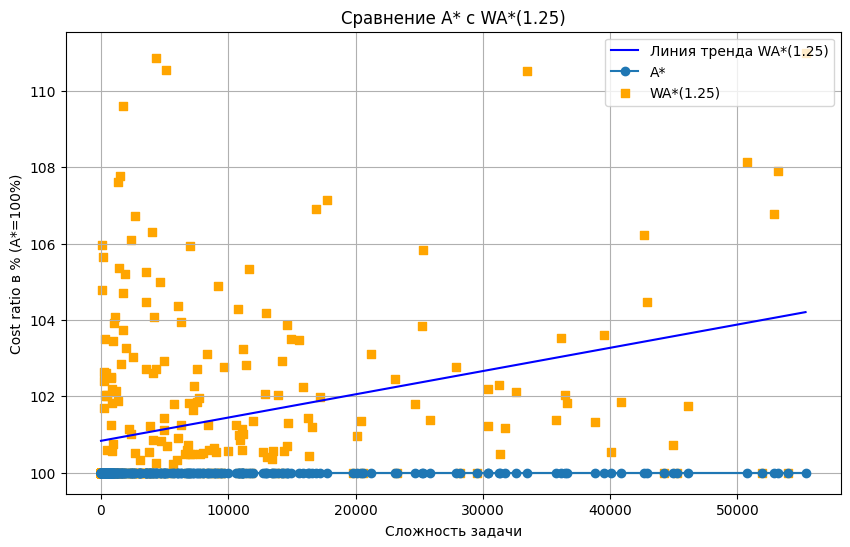

In [15]:
for wastar_modification in ["WA*(1.25)"]:
    plt.figure(figsize=(10, 6))

    coefficients = np.polyfit(problem_size_list, deviation_from_correct_stat[wastar_modification], 1)
    polynomial = np.poly1d(coefficients)

    x_line = np.linspace(min(problem_size_list), max(problem_size_list), 100)
    y_line = polynomial(x_line)
    plt.plot(x_line, y_line, label=f'Линия тренда {wastar_modification}', color='blue')

    plt.plot(problem_size_list, deviation_from_correct_stat['A*'], label='A*', marker='o')
    plt.scatter(problem_size_list, deviation_from_correct_stat[wastar_modification], label=f'{wastar_modification}', marker='s', c='orange')

    plt.title(f'Сравнение A* с {wastar_modification}')
    plt.xlabel('Сложность задачи')
    plt.ylabel('Cost ratio в % (A*=100%)')
    plt.legend()
    plt.grid(True)

    plt.show()

По этому графику можем наблюдать, что разброс характеристики Cost Ratio  от задачи у WA*очень большой и судя по нему сложно выдать какую-то оценку. Поэтому для сравления алгоритмов будем по облаку точек строить линию тренда и сравнивать их.

In [16]:
def draw_trands(stat, names):
    for wastar_modification in names:
        coefficients = np.polyfit(problem_size_list, stat[wastar_modification], 1)
        polynomial = np.poly1d(coefficients)

        x_line = np.linspace(min(problem_size_list), max(problem_size_list), 100)
        y_line = polynomial(x_line)
        plt.plot(x_line, y_line, label=f'Линия тренда {wastar_modification}')

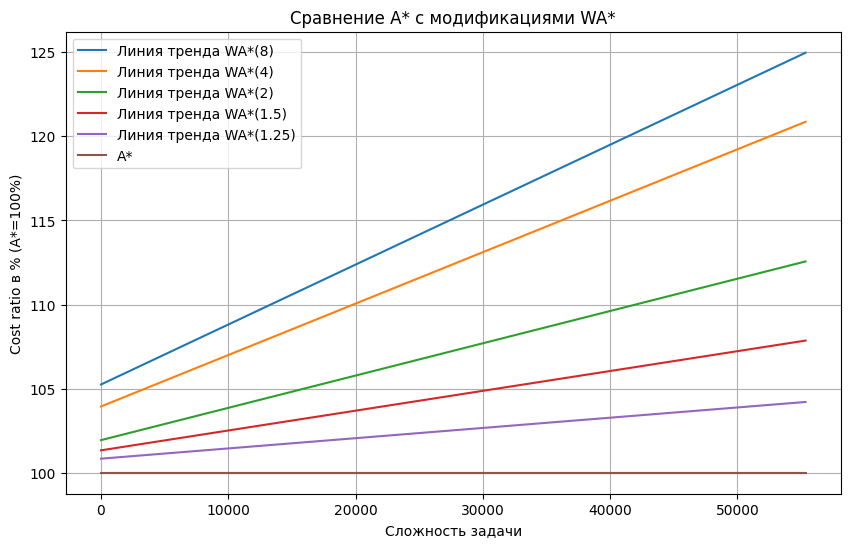

In [17]:
plt.figure(figsize=(10, 6))

draw_trands(deviation_from_correct_stat, reversed(["WA*(1.25)", "WA*(1.5)", "WA*(2)", "WA*(4)", "WA*(8)"]))

plt.plot(problem_size_list, deviation_from_correct_stat['A*'], label='A*')
plt.title(f'Сравнение A* с модификациями WA*')
plt.xlabel('Сложность задачи')
plt.ylabel('Cost ratio в % (A*=100%)')
plt.legend()
plt.grid(True)

plt.show()

Чем сложнее задача, тем больше субоптимальные алгоритмы начинают приближаться к максимальному коэффициенту субоптимальности.
Также, чем больше коэффициент субоптимальности, тем хуже ответ выдает алгоритм.

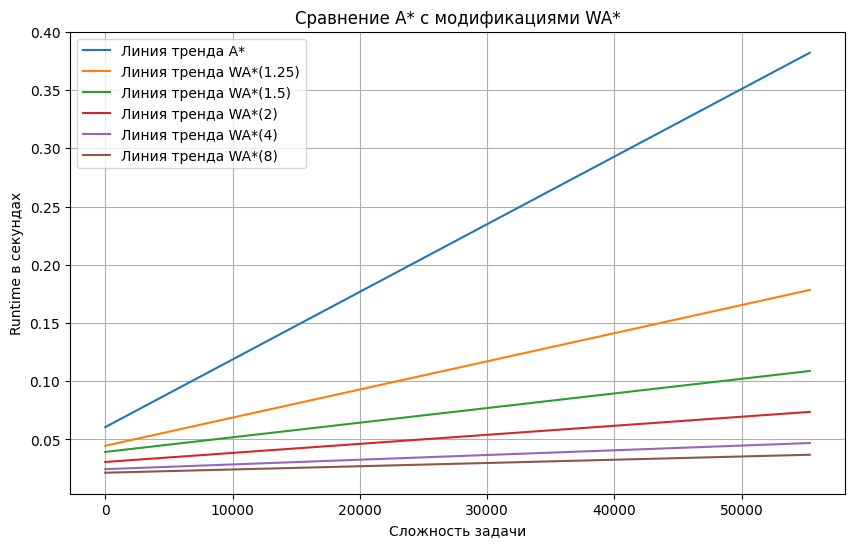

In [18]:
plt.figure(figsize=(10, 6))

draw_trands(elapsed_time_stat, ["A*", "WA*(1.25)", "WA*(1.5)", "WA*(2)", "WA*(4)", "WA*(8)"])

plt.title(f'Сравнение A* с модификациями WA*')
plt.xlabel('Сложность задачи')
plt.ylabel('Runtime в секундах')
plt.legend()
plt.grid(True)

plt.show()

Ожидаемо, что чем сложнее задача, тем больше времени работает любой из алгоритмов. 
Также, наблюдаем тренд на то, что чем больше коэффициент субоптимальности, тем быстрее будет выдан ответ.

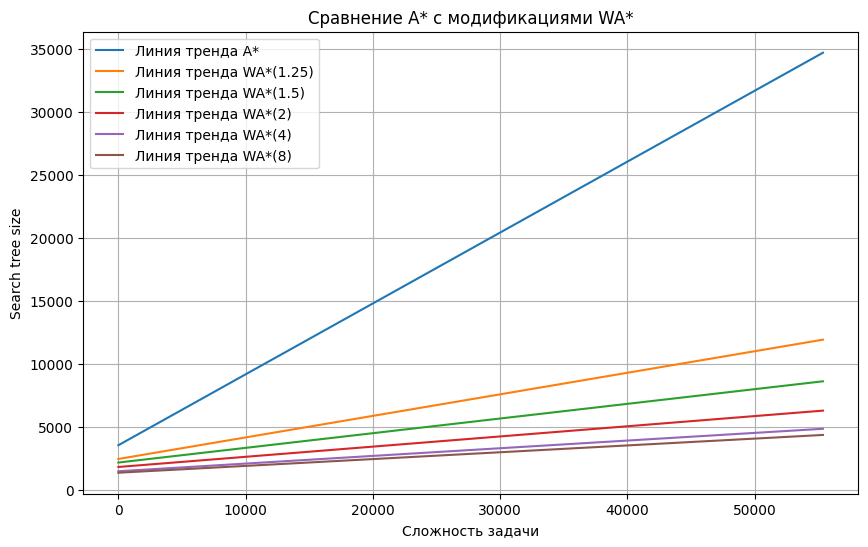

In [19]:
plt.figure(figsize=(10, 6))

draw_trands(search_tree_size_stat, ["A*", "WA*(1.25)", "WA*(1.5)", "WA*(2)", "WA*(4)", "WA*(8)"])

plt.title(f'Сравнение A* с модификациями WA*')
plt.xlabel('Сложность задачи')
plt.ylabel('Search tree size')
plt.legend()
plt.grid(True)

plt.show()

Так как время работы алгоритма и search tree size достаточно скоррелированные величины, можно сделать выводы аналогичные графику выше. 

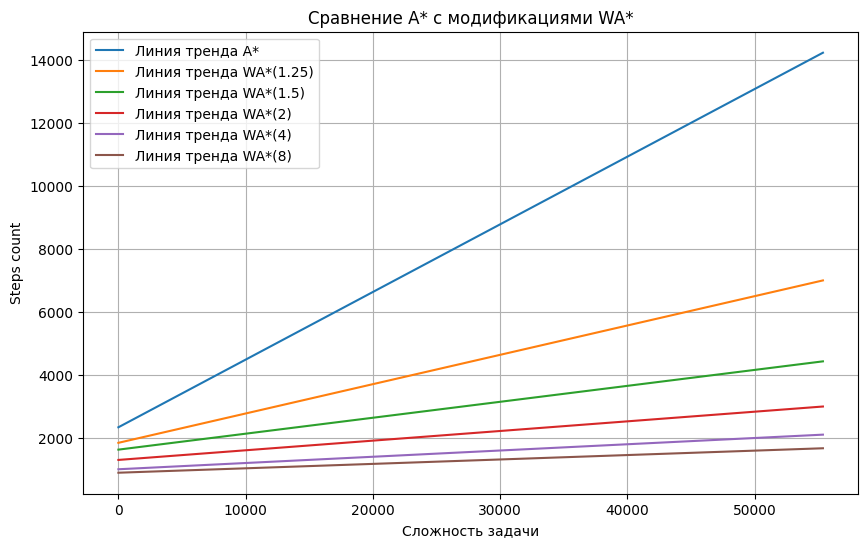

In [20]:
plt.figure(figsize=(10, 6))

draw_trands(steps_stat, ["A*", "WA*(1.25)", "WA*(1.5)", "WA*(2)", "WA*(4)", "WA*(8)"])

plt.title(f'Сравнение A* с модификациями WA*')
plt.xlabel('Сложность задачи')
plt.ylabel('Steps count')
plt.legend()
plt.grid(True)

plt.show()

Так как время работы алгоритма и число шагов достаточно скоррелированные величины, можно сделать выводы аналогичные графику выше. 

In [21]:
mean_search_tree = search_tree_size_stat.mean(axis=0)
mean_deviation = deviation_from_correct_stat.mean(axis=0)

In [22]:
algorithms = ["A*", "WA*(1.25)", "WA*(1.5)", "WA*(2)", "WA*(4)", "WA*(8)"]

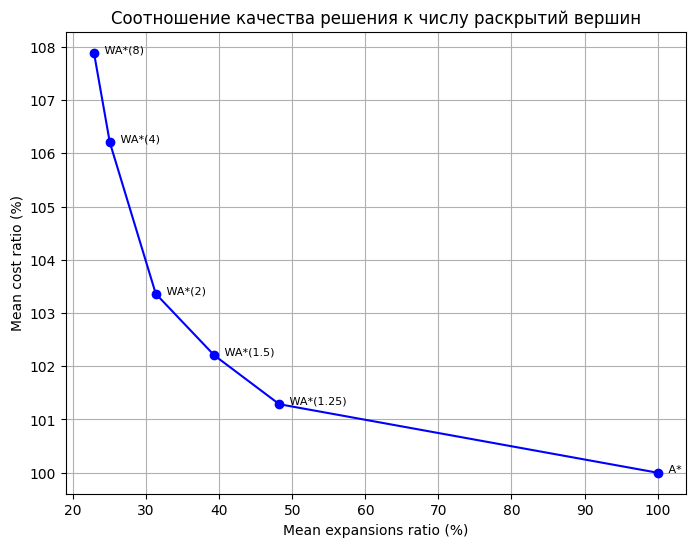

In [23]:
search_tree_max = mean_search_tree.max()
deviation_max = mean_deviation.min()

x = []
y = []
labels = algorithms

for algorithm in algorithms:
    x.append(mean_search_tree[algorithm] / search_tree_max * 100)
    y.append(mean_deviation[algorithm] / deviation_max * 100)

plt.figure(figsize=(8, 6))
plt.plot(x, y, color='blue', marker='o')  # Рисуем точки

for i in range(len(x)):
    plt.text(x[i], y[i], f'   {labels[i]}', fontsize=8, ha='left')

plt.autoscale()

plt.xlabel('Mean expansions ratio (%)')
plt.ylabel('Mean cost ratio (%)')
plt.title("Соотношение качества решения к числу раскрытий вершин")

plt.grid()
plt.show()


Наглядно прослеживается tradeoff: чем ближе решение к оптимальному (чем меньше коэфициент у WA*), тем больше раскрытий вершин приходится делать и наоборот.